# Use PyMC Model for Bayes Hierarchical RL
- Estimate learning rate (i.e. alpha) for each subject using this model

In [20]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
# import stan

import pymc3 as pm
import arviz as az
# import learning package
#import DMpy

In [57]:
# read scr file
scr = pd.read_csv('/media/Data/Lab_Projects/PTSD_Reversal/Behavioral/SCR3.csv')
scr.head()


Event.Nr  CDA.nSCR CDA.Latency  CDA.AmpSum  CDA.SCR  CDA.ISCR  \
0         1         5      0.8435      0.2852   0.0003    0.1339   
1         2         4      0.7335      0.1033   0.0012    0.4737   
2         3         3      2.9835      0.0783   0.0008    0.3237   
3         4         1      3.4935      0.1772   0.0002    0.0993   
4         5         0         NaN      0.0000   0.0004    0.1532   

   CDA.PhasicMax  CDA.Tonic  TTP.nSCR TTP.Latency  TTP.AmpSum  Global.Mean  \
0         8.1296     2.3324         1      3.9335      0.5884       2.4822   
1         0.3046     4.0029         0         NaN      0.0000       4.3933   
2         0.1352     3.9579         1      2.8335      0.0260       3.9900   
3         7.0748     3.8756         1      3.5335      0.5186       3.9212   
4         0.1604     4.2513         0         NaN      0.0000       4.3461   

   Global.MaxDeflection  Event.NID  Event.Name  Condition group  sub  
0                0.5884          5           5  CSplusUS1    HC  189  
1                0.0000          5           5   CSminus1    HC  189  
2                0.0154          5           5    CSplus1    HC  189  
3                0.5186          5           5  CSplusUS1    HC  189  
4                0.0000          5           5   CSminus1    HC  189

In [58]:
scr = scr[['sub','Condition','Event.Nr','CDA.AmpSum']]
scr['sub'] = scr['sub'].astype('string')
for i in scr.iterrows():
    if len(i[1]['sub'])<=2:
        #print(i[1]['sub'])
        sub = 'sub-0' + str(i[1]['sub'])
    else:
        sub = 'sub-' + str(i[1]['sub'])
    #print(sub)
    scr.at[i[0], 'sub'] = sub
    

In [61]:
len(scr['sub'].unique())

101

In [63]:
# grab subjects with 69 trials
scr_clean = scr.copy() # make a copy of original
for sub in scr['sub'].unique():
    df = scr[scr['sub']==sub]
    #print (len(df))
    if len(df)<69:
        scr_clean = scr_clean[scr_clean['sub']!=sub]
len(scr_clean['sub'].unique()) # total of 86 valid subjects

86

In [45]:
# grab just two subjects for now
scrTwo = scr_clean#[(scr['sub']==152) |(scr['sub']==189) | (scr['sub']==86) | (scr['sub']==48)]
scrTwo['Event.Nr'].values

array([ 1,  2,  3, ..., 67, 68, 69])

Organize the data for the analysis

In [46]:
# organize data accordingly
# first, grab just the relevant variables (subject, trial, stimuli, shock)
# we need to generate a new variable shock (1=yes, 0=no)
# we also need a new variable stim (1=CS+, 2=CS-)
scrVec = scrTwo['CDA.AmpSum'].values
print(scrVec.shape)
shockVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture shock (1=yes, 0=no)
stimVec = np.zeros(len(scrVec), dtype=np.int32) # vector to capture stimulus (1=CS+, 2= CS-)

for i, cond in enumerate(scrTwo['Condition'].values):
    if cond=='CSplusUS1':
        shockVec[i]= 1
        stimVec[i] = 1
    elif cond=='CSminusUS2':
            # after reversal so minus becomes plus
        shockVec[i]= 1
        stimVec[i] = 0
    elif cond=='CSplus2':
            # after reversal so plus becomes minus
            shockVec[i]=0
            stimVec[i] = 1
    elif cond=='CSplus1':
            stimVec[i] = 1
            shockVec[i]= 0
    elif cond=='CSminus1':
            stimVec[i] = 0
            shockVec[i] = 0
print(shockVec.shape)
print(stimVec.shape)

(5934,)
(5934,)
(5934,)


In [47]:
n_trials, n_subj = 69,len(scrTwo['sub'].unique())
trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = tt.as_tensor_variable(trials.T)
subj = tt.as_tensor_variable(subj.T)
stim = np.reshape(stimVec, (n_subj,n_trials)).T # transform to matrix trials x subject
shock = np.reshape(shockVec, (n_subj,n_trials)).T 
scrMat = np.reshape(scrVec, (n_subj, n_trials)).T

In [48]:
stim = tt.as_tensor_variable(stim)
shock = tt.as_tensor_variable(shock)


# Build PyMC code

In [49]:
#scrs = tt.zeros(30) # set empty scr tensor (vector)
   
# generate functions to run
def update_Q(stim, shock,
             Qs,vec,
             alpha, n_subj):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by theano.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the theano.scan fn argument:
        fn=lamba action, reward, Qs, alpha: tt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
      
    PE = shock - Qs[tt.arange(n_subj), stim]
    Qs = tt.set_subtensor(Qs[tt.arange(n_subj),stim], Qs[tt.arange(n_subj),stim] + alpha * PE)
    
    # in order to get a vector of expected outcome (dependent on the stimulus presentes [CS+, CS-] 
    # we us if statement (switch in theano)
    vec = tt.set_subtensor(vec[tt.arange(n_subj),0], (tt.switch(tt.eq(stim,1), 
                                                                Qs[tt.arange(n_subj),1], Qs[tt.arange(n_subj),0])))
    
    return Qs, vec

def theano_llik_td(alpha,  stim, shock, n_subj):
   # stim = theano.shared(np.asarray(stim, dtype='int16'))
   # shock = theano.shared(np.asarray(shock, dtype='int16'))

    # Compute the Qs values
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])

       
    return Qs, vec

In [50]:
with pm.Model() as m:
  
      
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 533 seconds.


array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>],
       [<AxesSubplot:title={'center':'expected_value'}>,
        <AxesSubplot:title={'center':'expected_value'}>]], dtype=object)

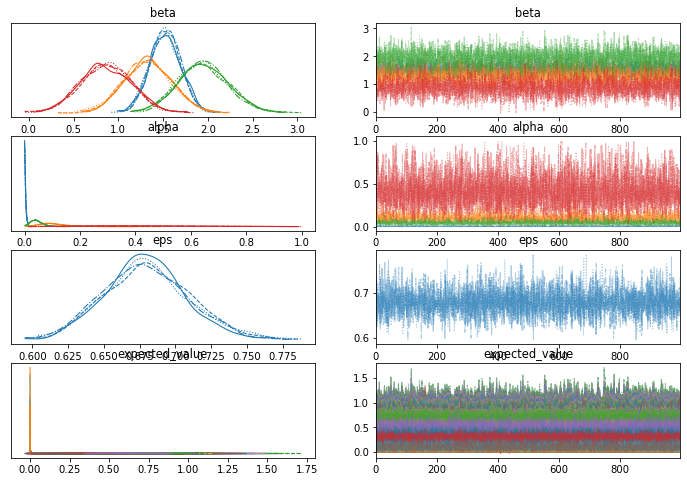

In [31]:
az.plot_trace(tr)

In [83]:
az.summary(tr)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   1.529  0.169   1.222    1.859      0.002    0.002    4919.0   
beta[1]   1.339  0.269   0.861    1.854      0.004    0.003    4146.0   
beta[2]   1.947  0.282   1.431    2.476      0.005    0.003    3634.0   
beta[3]   0.860  0.274   0.365    1.395      0.005    0.003    3284.0   
alpha[0]  0.004  0.004   0.000    0.010      0.000    0.000    3731.0   
alpha[1]  0.103  0.049   0.027    0.192      0.001    0.001    4103.0   
alpha[2]  0.044  0.022   0.002    0.082      0.000    0.000    3444.0   
alpha[3]  0.422  0.196   0.105    0.810      0.004    0.003    2878.0   
eps       0.679  0.029   0.625    0.735      0.000    0.000    4365.0   

          ess_tail  r_hat  
beta[0]     3037.0    1.0  
beta[1]     2872.0    1.0  
beta[2]     2889.0    1.0  
beta[3]     2775.0    1.0  
alpha[0]    1935.0    1.0  
alpha[1]    2467.0    1.0  
alpha[2]    1978.0    1.0  
alpha[3]    2005.0    1.0  
eps         2683.0    1.0

# Add intercept

In [84]:
# try alpha as beta distribution
with pm.Model() as m2:
  
    intercept = pm.Normal('intercept', 0,.5, shape=n_subj)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5, shape=n_subj)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trI = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 194 seconds.


In [85]:
az.summary(trI)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept[0]  0.800  0.140   0.556    1.083      0.003    0.003    1801.0   
intercept[1]  0.254  0.145  -0.021    0.507      0.003    0.002    2235.0   
intercept[2]  0.610  0.139   0.353    0.880      0.003    0.002    2644.0   
intercept[3] -0.005  0.115  -0.229    0.197      0.002    0.002    2632.0   
beta[0]      -0.193  0.407  -1.042    0.494      0.011    0.009    1701.0   
beta[1]       0.504  0.419  -0.228    1.297      0.009    0.007    2088.0   
beta[2]       0.405  0.385  -0.271    1.146      0.008    0.006    2386.0   
beta[3]       0.720  0.336   0.125    1.371      0.007    0.005    2355.0   
alpha[0]      0.381  0.298   0.000    0.906      0.007    0.005    2018.0   
alpha[1]      0.290  0.253   0.000    0.815      0.005    0.004    2423.0   
alpha[2]      0.334  0.264   0.000    0.851      0.005    0.004    2603.0   
alpha[3]      0.430  0.231   0.069    0.893      0.005    0.004    2097.0   
eps           0.687  0.031   0.633    0.748      0.001    0.000    2900.0   

              ess_tail  r_hat  
intercept[0]    1325.0    1.0  
intercept[1]    2569.0    1.0  
intercept[2]    2437.0    1.0  
intercept[3]    2548.0    1.0  
beta[0]         1527.0    1.0  
beta[1]         2723.0    1.0  
beta[2]         2377.0    1.0  
beta[3]         2444.0    1.0  
alpha[0]        2284.0    1.0  
alpha[1]        2571.0    1.0  
alpha[2]        2309.0    1.0  
alpha[3]        1361.0    1.0  
eps             2407.0    1.0

In [86]:
az.compare({'model1': tr, 'model2_intercept':trI}) 

rank         loo      p_loo     d_loo        weight  \
model1               0 -291.212865  13.005515  0.000000  1.000000e+00   
model2_intercept     1 -295.071378  13.793444  3.858513  2.220446e-15   

                         se       dse  warning loo_scale  
model1            33.452732  0.000000    False       log  
model2_intercept  32.654759  1.615413    False       log

# Set intercept as all subjects

In [87]:
with pm.Model() as m3:
  
    intercept = pm.Normal('intercept', 0,.5)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5, shape=n_subj)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    tr3 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 189 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [88]:
az.summary(tr3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.394  0.150   0.146    0.655      0.011    0.008     194.0   
beta[0]    0.638  0.378  -0.080    1.250      0.024    0.017     258.0   
beta[1]    0.189  0.400  -0.522    0.958      0.024    0.017     283.0   
beta[2]    0.857  0.406   0.048    1.555      0.025    0.018     272.0   
beta[3]   -0.200  0.510  -1.053    0.635      0.038    0.027     205.0   
alpha[0]   0.194  0.266   0.000    0.742      0.016    0.011     261.0   
alpha[1]   0.369  0.278   0.000    0.884      0.008    0.005    1437.0   
alpha[2]   0.160  0.182   0.000    0.524      0.008    0.006     443.0   
alpha[3]   0.294  0.319   0.000    0.873      0.020    0.014     252.0   
eps        0.707  0.032   0.647    0.766      0.001    0.001    1325.0   

           ess_tail  r_hat  
intercept    1450.0   1.02  
beta[0]      1904.0   1.01  
beta[1]      1390.0   1.01  
beta[2]      1440.0   1.01  
beta[3]      1599.0   1.01  
alpha[0]     1639.0   1.02  
alpha[1]     1342.0   1.00  
alpha[2]     1459.0   1.01  
alpha[3]     1664.0   1.01  
eps          2153.0   1.00

In [89]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3}) 

rank         loo      p_loo      d_loo        weight  \
model1                    0 -291.212865  13.005515   0.000000  1.000000e+00   
model2_intercept          1 -295.071378  13.793444   3.858513  0.000000e+00   
model3_jointIntercept     2 -302.038841  13.162076  10.825976  7.704948e-14   

                              se       dse  warning loo_scale  
model1                 33.452732  0.000000    False       log  
model2_intercept       32.654759  1.615413    False       log  
model3_jointIntercept  32.601366  2.355649    False       log

# Joint Slope

In [90]:
with pm.Model() as m4:
  
    intercept = pm.Normal('intercept', 0,.5,  shape=n_subj)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    tr4 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 184 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [91]:
az.summary(tr4)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept[0]  0.556  0.179   0.158    0.822      0.010    0.007     426.0   
intercept[1]  0.221  0.128  -0.043    0.443      0.005    0.003     751.0   
intercept[2]  0.552  0.131   0.299    0.783      0.005    0.003     823.0   
intercept[3]  0.014  0.110  -0.201    0.211      0.004    0.003     938.0   
beta          0.633  0.313   0.081    1.225      0.014    0.010     506.0   
alpha[0]      0.313  0.249   0.000    0.759      0.011    0.008     406.0   
alpha[1]      0.234  0.203   0.000    0.655      0.006    0.004    1596.0   
alpha[2]      0.255  0.215   0.000    0.693      0.005    0.004    2028.0   
alpha[3]      0.458  0.240   0.039    0.886      0.005    0.004    2519.0   
eps           0.690  0.030   0.635    0.747      0.001    0.000    2579.0   

              ess_tail  r_hat  
intercept[0]     700.0   1.01  
intercept[1]    1329.0   1.00  
intercept[2]    1304.0   1.00  
intercept[3]    1585.0   1.00  
beta             820.0   1.00  
alpha[0]         830.0   1.01  
alpha[1]        1633.0   1.00  
alpha[2]        2185.0   1.00  
alpha[3]        2084.0   1.00  
eps             2711.0   1.00

In [92]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4}) 

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


rank         loo      p_loo      d_loo        weight  \
model1                    0 -291.212865  13.005515   0.000000  1.000000e+00   
model2_intercept          1 -295.071378  13.793444   3.858513  0.000000e+00   
model4_jointBeta          2 -296.495549  13.603933   5.282683  0.000000e+00   
model3_jointIntercept     3 -302.038841  13.162076  10.825976  3.979039e-13   

                              se       dse  warning loo_scale  
model1                 33.452732  0.000000    False       log  
model2_intercept       32.654759  1.615413    False       log  
model4_jointBeta       32.596290  1.976725     True       log  
model3_jointIntercept  32.601366  2.355649    False       log

# Both intercept and slope are joined

In [34]:
with pm.Model() as m5:
  
    intercept = pm.Normal('intercept', 0,.5)  
    alpha = pm.Beta('alpha', 1,1, shape=n_subj)
    beta = pm.Normal('beta',0, .5)
    eps = pm.HalfNormal('eps', 1)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    tr5 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 180 seconds.


In [94]:
az.summary(tr5)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -0.002  0.116  -0.227    0.206      0.003    0.002    1772.0   
beta       1.458  0.279   0.909    1.954      0.007    0.005    1702.0   
alpha[0]   0.004  0.013   0.000    0.010      0.000    0.000    2245.0   
alpha[1]   0.114  0.063   0.027    0.225      0.001    0.001    2990.0   
alpha[2]   0.024  0.028   0.000    0.052      0.001    0.000    2460.0   
alpha[3]   0.342  0.129   0.128    0.592      0.003    0.002    2513.0   
eps        0.685  0.030   0.629    0.745      0.001    0.000    3393.0   

           ess_tail  r_hat  
intercept    1935.0    1.0  
beta         1793.0    1.0  
alpha[0]     1010.0    1.0  
alpha[1]     2275.0    1.0  
alpha[2]     1178.0    1.0  
alpha[3]     1956.0    1.0  
eps          2612.0    1.0

In [95]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5}) 

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


rank         loo      p_loo      d_loo        weight  \
model1                    0 -291.212865  13.005515   0.000000  6.880626e-01   
model5                    1 -291.573924   9.441923   0.361059  3.119374e-01   
model2_intercept          2 -295.071378  13.793444   3.858513  1.193764e-13   
model4_jointBeta          3 -296.495549  13.603933   5.282683  1.186284e-13   
model3_jointIntercept     4 -302.038841  13.162076  10.825976  0.000000e+00   

                              se       dse  warning loo_scale  
model1                 33.452732  0.000000    False       log  
model5                 32.239086  3.820305    False       log  
model2_intercept       32.654759  1.615413    False       log  
model4_jointBeta       32.596290  1.976725     True       log  
model3_jointIntercept  32.601366  2.355649    False       log

## Use reparametarization on $\alpha$

In [97]:
with pm.Model() as m_pooled:
    intercept = pm.Normal('intercept', 0, 2)
    alpha_mu = pm.Beta('alpha_mu', 1, 1)
    alpha_sd = pm.HalfNormal('alpha_sd',.5)
    alpha_matt = pm.Normal('alpha_matt', mu=0, sd=1, shape=n_subj)
    alpha = pm.Deterministic('alpha', alpha_mu + alpha_sd * alpha_matt)
    beta = pm.Normal('beta',0, 5, shape= n_subj)
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_1 = pm.sample(target_accept=.9, chains=4, cores=8, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [eps, beta, alpha_matt, alpha_sd, alpha_mu, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1077 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8347807418049349, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [98]:
az.summary(trH_1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept      0.963  1.529  -1.048    3.382      0.729    0.554       6.0   
alpha_matt[0] -0.268  1.031  -2.064    1.525      0.443    0.332       6.0   
alpha_matt[1] -0.353  0.642  -1.479    0.865      0.237    0.175       8.0   
alpha_matt[2] -0.540  0.529  -1.608    0.360      0.166    0.121      10.0   
alpha_matt[3]  0.006  0.875  -1.443    1.580      0.363    0.270       6.0   
beta[0]       -1.262  3.125  -6.219    2.751      1.480    1.124       6.0   
beta[1]       -0.422  3.182  -5.243    3.870      1.519    1.155       6.0   
beta[2]        0.165  3.137  -4.713    4.302      1.497    1.138       6.0   
beta[3]       -0.913  3.237  -5.834    3.492      1.546    1.175       6.0   
alpha_mu       0.035  0.038   0.000    0.115      0.011    0.008      11.0   
alpha_sd       0.069  0.050   0.009    0.164      0.012    0.009      13.0   
alpha[0]      -0.002  0.035  -0.052    0.049      0.017    0.013       6.0   
alpha[1]       0.021  0.041  -0.030    0.091      0.018    0.014       6.0   
alpha[2]       0.008  0.029  -0.035    0.058      0.013    0.010       6.0   
alpha[3]       0.053  0.083  -0.030    0.216      0.033    0.025       6.0   
eps            0.652  0.029   0.597    0.704      0.002    0.002     183.0   

               ess_tail  r_hat  
intercept         207.0   1.74  
alpha_matt[0]     120.0   1.74  
alpha_matt[1]     187.0   1.50  
alpha_matt[2]      95.0   1.33  
alpha_matt[3]     153.0   1.71  
beta[0]           229.0   1.74  
beta[1]           208.0   1.74  
beta[2]           183.0   1.75  
beta[3]           150.0   1.74  
alpha_mu           28.0   1.30  
alpha_sd          314.0   1.23  
alpha[0]          133.0   1.74  
alpha[1]          126.0   1.73  
alpha[2]          107.0   1.75  
alpha[3]           53.0   1.76  
eps              1042.0   1.03

In [99]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5, 'pooledAlpha':trH_1}) 

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential obse

rank         loo      p_loo      d_loo    weight  \
pooledAlpha               0 -281.194424  17.036173   0.000000  0.870946   
model1                    1 -291.212865  13.005515  10.018441  0.000000   
model5                    2 -291.573924   9.441923  10.379500  0.129054   
model2_intercept          3 -295.071378  13.793444  13.876954  0.000000   
model4_jointBeta          4 -296.495549  13.603933  15.301125  0.000000   
model3_jointIntercept     5 -302.038841  13.162076  20.844417  0.000000   

                              se       dse  warning loo_scale  
pooledAlpha            34.687106  0.000000     True       log  
model1                 33.452732  4.057574    False       log  
model5                 32.239086  6.332183    False       log  
model2_intercept       32.654759  4.210021    False       log  
model4_jointBeta       32.596290  4.666778     True       log  
model3_jointIntercept  32.601366  4.624160    False       log

# Pooling intercet , slope and alpha

In [101]:
with pm.Model() as m_pooled2:
    
    intercept_mu = pm.Normal('intercept_mu', 0, 1)
    intercept_sd = pm.HalfNormal('intercept_sd',5)
    intercept_matt = pm.Normal('alpha_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_mu + intercept_sd * intercept_matt)
    
    alpha = pm.Beta('alpha', 1, 1, shape = n_subj)
   
    beta_mu = pm.Normal('beta_mu', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta_matt = pm.Normal('beta_matt', 0,1, shape=n_subj)
    beta = pm.Deterministic('beta', beta_mu + beta_sd*beta_matt)
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_2 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta_matt, beta_sd, beta_mu, alpha, alpha_matt, intercept_sd, intercept_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1654 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [102]:
az.compare({'model1': tr, 'model2_intercept':trI, 'model3_jointIntercept':tr3,
           'model4_jointBeta':tr4, 'model5': tr5, 'pooledAlpha':trH_1, 'fully_pooled':trH_2}) 

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential obse

rank         loo      p_loo      d_loo        weight  \
pooledAlpha               0 -281.194424  17.036173   0.000000  8.709751e-01   
fully_pooled              1 -284.960080  16.935107   3.765656  1.763689e-13   
model1                    2 -291.212865  13.005515  10.018441  1.795988e-13   
model5                    3 -291.573924   9.441923  10.379500  1.290249e-01   
model2_intercept          4 -295.071378  13.793444  13.876954  2.367857e-13   
model4_jointBeta          5 -296.495549  13.603933  15.301125  1.931479e-13   
model3_jointIntercept     6 -302.038841  13.162076  20.844417  1.913469e-12   

                              se       dse  warning loo_scale  
pooledAlpha            34.687106  0.000000     True       log  
fully_pooled           33.263352  2.387974     True       log  
model1                 33.452732  4.057574    False       log  
model5                 32.239086  6.332183    False       log  
model2_intercept       32.654759  4.210021    False       log  
model4_jointBeta       32.596290  4.666778     True       log  
model3_jointIntercept  32.601366  4.624160    False       log

# Similar to Stan model

In [ ]:
with pm.Model() as m_stan:
    mu = pm.Normal('mu', 0, 1, shape=3)
    sd = pm.HalfNormal('sd',5, shape=3)
     
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu[1]*sd[1] )
    
    
    alpha_h = pm.Beta('alpha_h',1,  1, shape = n_subj)
    alpha = pm.Deterministic('alpha', alpha_h + mu[0]* sd[0])
    
    
    beta_matt = pm.Normal('beta_matt',0, 1, shape=n_subj)
    beta = pm.Deterministic('beta', beta_matt + mu[2]*sd[2])
    
    eps = pm.HalfNormal('eps', 5)
  
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = intercept[subj] + vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    
    trH_Stan = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta_matt, alpha_h, alpha_matt, sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1602 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 417 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5589460571641848, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1602 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or repar

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero enc

# Model using hyperparameter in different way
- For reference:
https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/hierarchical_partial_pooling.html

In [10]:
with pm.Model() as m5:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    trH_phi = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 377 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6624117962788686, but should be close to 0.9. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7894920569902244, but should be close to 0.9. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8365201880026214, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
az.summary(trH_phi)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_h     1.361  0.306   0.713    1.824      0.014    0.010     448.0   
beta[0]    1.518  0.145   1.224    1.768      0.007    0.005     489.0   
beta[1]    1.403  0.229   0.975    1.843      0.011    0.008     455.0   
beta[2]    1.736  0.283   1.238    2.229      0.015    0.011     349.0   
beta[3]    1.146  0.279   0.645    1.639      0.017    0.012     279.0   
phi        0.180  0.104   0.035    0.375      0.009    0.008     232.0   
kappa_log  0.539  0.479   0.001    1.420      0.025    0.018     154.0   
kappa      1.981  1.525   1.001    4.136      0.043    0.031     154.0   
alpha[0]   0.001  0.002   0.000    0.005      0.000    0.000     341.0   
alpha[1]   0.091  0.042   0.017    0.174      0.002    0.001     702.0   
alpha[2]   0.027  0.022   0.000    0.064      0.001    0.001     391.0   
alpha[3]   0.305  0.139   0.068    0.575      0.009    0.007     248.0   
beta_sd    0.449  0.333   0.017    1.033      0.018    0.013     166.0   
eps        0.677  0.030   0.622    0.735      0.002    0.001     263.0   

           ess_tail  r_hat  
beta_h        818.0   1.01  
beta[0]       743.0   1.00  
beta[1]       676.0   1.01  
beta[2]       597.0   1.01  
beta[3]       509.0   1.00  
phi           131.0   1.01  
kappa_log     124.0   1.04  
kappa         124.0   1.04  
alpha[0]      272.0   1.00  
alpha[1]      451.0   1.01  
alpha[2]      435.0   1.01  
alpha[3]      370.0   1.01  
beta_sd        63.0   1.01  
eps           165.0   1.01

### Same but with intercept

In [12]:
with pm.Model() as m5_intercept:
    
    # intercept
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',5) 
    intercept_matt = pm.Normal('intercept_matt', mu=0, sd=1, shape=n_subj)
    intercept = pm.Deterministic('intercept',intercept_matt + mu*sd)
    
    # \alpha
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # \beta
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    trH_phi2 = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, beta_sd, beta_h, alpha, kappa_log, phi, intercept_matt, sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 426 seconds.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7902845005617887, but should be close to 0.9. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [14]:
az.summary(trH_phi2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu                -0.037  1.016  -1.857    1.888      0.037    0.026   
intercept_matt[0] -0.055  1.038  -2.068    1.793      0.056    0.040   
intercept_matt[1] -0.013  1.007  -1.962    1.873      0.021    0.019   
intercept_matt[2] -0.014  0.980  -1.790    1.837      0.018    0.018   
intercept_matt[3] -0.036  1.019  -1.917    1.915      0.023    0.018   
beta_h             1.304  0.396   0.545    1.952      0.013    0.009   
beta[0]            1.523  0.157   1.219    1.810      0.003    0.002   
beta[1]            1.385  0.262   0.843    1.857      0.013    0.010   
beta[2]            1.758  0.298   1.237    2.325      0.010    0.007   
beta[3]            1.116  0.295   0.578    1.664      0.013    0.010   
sd                 3.965  2.994   0.003    9.227      0.052    0.036   
intercept[0]      -0.193  5.068 -11.270    8.644      0.202    0.143   
intercept[1]      -0.151  5.054  -9.885    9.856      0.157    0.111   
intercept[2]      -0.152  5.048 -10.529    9.226      0.143    0.101   
intercept[3]      -0.174  5.045 -10.448    9.150      0.164    0.116   
phi                0.174  0.092   0.028    0.346      0.003    0.002   
kappa_log          0.538  0.494   0.000    1.451      0.013    0.009   
kappa              2.010  1.680   1.000    4.268      0.034    0.024   
alpha[0]           0.001  0.002   0.000    0.005      0.000    0.000   
alpha[1]           0.090  0.045   0.000    0.166      0.002    0.001   
alpha[2]           0.028  0.022   0.000    0.065      0.001    0.001   
alpha[3]           0.314  0.148   0.070    0.602      0.003    0.002   
beta_sd            0.610  0.622   0.038    1.570      0.023    0.017   
eps                0.679  0.030   0.624    0.736      0.001    0.000   

                   ess_bulk  ess_tail  r_hat  
mu                    798.0    1065.0   1.01  
intercept_matt[0]     359.0     119.0   1.02  
intercept_matt[1]    2294.0    2210.0   1.00  
intercept_matt[2]    3115.0    2415.0   1.00  
intercept_matt[3]    1889.0    2254.0   1.00  
beta_h               1096.0    1156.0   1.00  
beta[0]              2388.0    1859.0   1.00  
beta[1]               440.0     214.0   1.01  
beta[2]               879.0    2168.0   1.01  
beta[3]               445.0     655.0   1.01  
sd                   1992.0    1362.0   1.00  
intercept[0]          571.0     774.0   1.01  
intercept[1]          752.0    1359.0   1.01  
intercept[2]          804.0    1553.0   1.01  
intercept[3]          740.0    1348.0   1.01  
phi                  1007.0     877.0   1.00  
kappa_log             358.0      40.0   1.01  
kappa                 358.0      40.0   1.01  
alpha[0]              838.0     905.0   1.00  
alpha[1]              425.0     119.0   1.01  
alpha[2]              444.0     193.0   1.01  
alpha[3]             2211.0    1773.0   1.00  
beta_sd               273.0     119.0   1.01  
eps                  2648.0    2133.0   1.00

In [17]:
az.compare({'model1': trH_phi, 'model2':trH_phi2}, ic='loo')

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential obse

rank         loo      p_loo     d_loo  weight         se       dse  \
model1     0 -290.701393  12.620024  0.000000     1.0  33.133720  0.000000   
model2     1 -291.473844  13.577017  0.772451     0.0  33.013486  0.466334   

        warning loo_scale  
model1     True       log  
model2     True       log

## Takle the better model, remove pooling of $\beta$

In [18]:
with pm.Model() as m5_b:
    
    # α
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))
    alpha = pm.Beta("alpha", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=n_subj)
    
    # β
    # beta_h = pm.Normal('beta_h', 0,1)
    # beta_sd = pm.HalfNormal('beta_sd', 5)
    beta = pm.Normal('beta',0, 1, shape=n_subj)
       
    eps = pm.HalfNormal('eps', 5)
    
    Qs = 0.5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec0 = 0.5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_Q,
        sequences=[stim, shock],
        outputs_info=[Qs, vec0],
        non_sequences=[alpha, n_subj])
   
     
    vec_ = vec[trials, subj,0] * beta[subj]
    
    scrs = pm.Normal('scrs', vec_, eps, observed=scrMat) 
    trH_phiB = pm.sample(target_accept=.9, chains=4, cores=10, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, beta, alpha, kappa_log, phi]


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/step_methods/hmc/integration.py:108: RuntimeWarning: invalid value encountered in double_scalars
  energy = kinetic - logp
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 279 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31817602002139034, but should be close to 0.9. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.831747482365571, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective s

In [ ]:
az.compare({'model1': trH_phi, 'model2':trH_phi2, 'model3':trH_phiB}, ic='loo')

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential obse

rank         loo      p_loo     d_loo    weight         se       dse  \
model1     0 -290.701393  12.620024  0.000000  0.691708  33.133720  0.000000   
model3     1 -291.310586  13.011681  0.609193  0.308292  33.445514  1.706632   
model2     2 -291.473844  13.577017  0.772451  0.000000  33.013486  0.466334   

        warning loo_scale  
model1     True       log  
model3     True       log  
model2     True       log

# Correlate with actual data

In [51]:
# stack all chains
a = tr.posterior.stack(draws=('chain','draw'))
a = a.expected_value

In [96]:
mean_a = np.mean(a, axis=2)
mean_a.shape

(69, 86)

In [53]:
# calculate 
for i in np.arange(n_subj):
    cor1 = scipy.stats.pearsonr(scrMat[:,i], mean_a[:,i])
    print(cor1)

(-0.3325534002145948, 0.005240487345943555)
(0.5820544962358862, 1.556707277651035e-07)
(0.9592604437007094, 1.680486162374203e-38)
(0.5387277137957185, 1.7953613355191211e-06)
(0.41488990736249654, 0.0003932646922224949)
(0.7239859924977142, 2.075305823170287e-12)
(0.3664439343351513, 0.0019562821038196913)
(0.17389212393645928, 0.15300985885811366)
(0.5430596147229119, 1.4275624637511067e-06)
(0.4096459554541898, 0.00047345374208745424)
(0.30231289226903624, 0.011579753571257944)
(0.7392142415911422, 4.08102682917774e-13)
(0.5998759196521922, 5.1175585035569995e-08)
(0.21259387160388374, 0.07946752871995134)
(0.4275631786823597, 0.000247980633226184)
(0.05711475634152899, 0.6411122045715059)
(0.43955492950155006, 0.00015759582032474757)
(0.5447806194016991, 1.3021323820604427e-06)
(0.5256272378814081, 3.5232854830849364e-06)
(0.7030477179719847, 1.641252529194763e-11)
(0.7184517876057638, 3.64994651130648e-12)
(0.3485959638305381, 0.0033308376064671566)
(0.38238583853588204, 0.001184

In [104]:
# seems that some subjects are really problematic. 
# should consider removing them from analysis
scr_clean['sub'].unique()
mean_a_vec = np.reshape(mean_a.T, (69*86,1)) # reshape to fit dataframe

In [106]:
len(scr_clean)
scr_clean['expected_value'] = mean_a_vec.values

In [125]:
scr_clean['scr'] = scr_clean['CDA.AmpSum']

# Load brain data
Hippocampus - amygdala coupling

In [107]:
amg_hipp = pd.read_csv('amg_hipp_fc_allTrials.csv')
amg_hipp


index  subject  trialNo  condition  coupling       amg
0         0  sub-167        1  CSplusUS1  0.761905 -0.665134
1         1  sub-167        2   CSminus1 -0.238095 -0.060757
2         2  sub-167        3    CSplus1  0.095238  0.984678
3         3  sub-167        4  CSplusUS1  0.523810  0.488085
4         4  sub-167        5   CSminus1 -0.428571  0.053875
...     ...      ...      ...        ...       ...       ...
5101   1720  sub-200       65   CSminus2 -0.023810 -0.128837
5102   1721  sub-200       66    CSplus2 -0.500000 -0.126025
5103   1722  sub-200       67   CSminus2 -0.119048 -0.097882
5104   1723  sub-200       68    CSplus2  0.452381  0.117315
5105   1724  sub-200       69   CSminus2  0.400000 -0.397169

[5106 rows x 6 columns]

In [127]:
dfAll = pd.merge(scr_clean, amg_hipp, right_on=['subject','trialNo'], left_on=['sub','Event.Nr'])
dfAll.head()

sub  Condition  Event.Nr  CDA.AmpSum  expected_value     scr  index  \
0  sub-189  CSplusUS1         1      0.2852        0.765076  0.2852   1794   
1  sub-189   CSminus1         2      0.1033        0.762212  0.1033   1795   
2  sub-189    CSplus1         3      0.0783        0.763638  0.0783   1796   
3  sub-189  CSplusUS1         4      0.1772        0.765070  0.1772   1797   
4  sub-189   CSminus1         5      0.0000        0.760785  0.0000   1798   

   subject  trialNo  condition  coupling       amg  
0  sub-189        1  CSplusUS1  0.309524  0.981121  
1  sub-189        2   CSminus1 -0.571429 -0.027048  
2  sub-189        3    CSplus1 -0.476190 -0.045910  
3  sub-189        4  CSplusUS1  0.166667 -0.674150  
4  sub-189        5   CSminus1  0.214286 -0.065602

In [109]:
len(dfAll['sub'].unique())

65

In [132]:
# Statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
glm = smf.mixedlm('expected_value ~ coupling + C(condition) + amg', data=dfAll, 
    groups = 'subject', 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    expected_value
No. Observations:    4485       Method:                REML          
No. Groups:          65         Scale:                 0.1771        
Min. group size:     69         Log-Likelihood:        -2647.0340    
Max. group size:     69         Converged:             Yes           
Mean group size:     69.0                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.310    0.060  5.127 0.000  0.192  0.429
C(condition)[T.CSminus2]    0.028    0.020  1.404 0.160 -0.011  0.067
C(condition)[T.CSminusUS2]  0.232    0.025  9.307 0.000  0.183  0.280
C(condition)[T.CSplus1]     0.175    0.021  8.177 0.000  0.133  0.216
C(condition)[T.CSplus2]    -0.139   

# Summary:
- Amg-Hippocampus coupling is significantly predicting expected value!
